In [46]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, f1_score
import joblib

In [40]:
# Load data
df = pd.read_csv('mochi_activities_3.csv')

# Feature engineering
df['hour_sin'] = np.sin(2 * np.pi * df['Time']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['Time']/24)
df['is_weekend'] = df['Day'].isin(['Saturday', 'Sunday']).astype(int)

# Define features/target
X = df[['hour_sin', 'hour_cos', 'Duration_minutes', 'Location', 
        'Weather', 'People_home', 'Mood', 'Reward_given', 'is_weekend']]
y = df['Activity']

In [82]:
# Preprocessing
categorical_features = ['Location', 'Weather', 'Mood', 'Reward_given']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Create base pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': ['balanced', None]
}


# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring= "f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=2
)


In [83]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)  # Specific warning type
warnings.filterwarnings('ignore', message='exact warning message')  # By message text

import warnings
from sklearn.exceptions import FitFailedWarning

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import joblib

# Simple train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                   random_state=42, stratify=y)

# Train model
print("Training model")
grid_search.fit(X_train, y_train)


Training model
Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   0.1s
[CV] END classifie

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Location',
                                                                          'Weather',
                                                                          'Mood',
                                                                          'Reward_given'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [5, 10, 15, None],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100]},
             scoring='f1_weighted', verbose=2)

In [85]:
# Show results
print("\nBest params:", grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Evaluate
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nTest Report:")
print(classification_report(y_test, y_pred))


Best params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best CV score: 0.8379

Test Report:
                  precision    recall  f1-score   support

         Barking       0.89      0.84      0.86        19
Begging for food       0.80      1.00      0.89        12
   Cutting nails       0.75      1.00      0.86         3
          Eating       0.91      1.00      0.95        20
         Haircut       0.00      0.00      0.00         2
    On the couch       0.89      1.00      0.94        17
          Peeing       0.67      0.62      0.65        16
   Playing fetch       0.91      0.83      0.87        12
         Pooping       0.73      0.85      0.79        13
          Shower       1.00      1.00      1.00         3
        Sleeping       1.00      0.80      0.89        10
           Trick       1.00      0.71      0.83         7
         Walking     

<Figure size 1000x800 with 0 Axes>

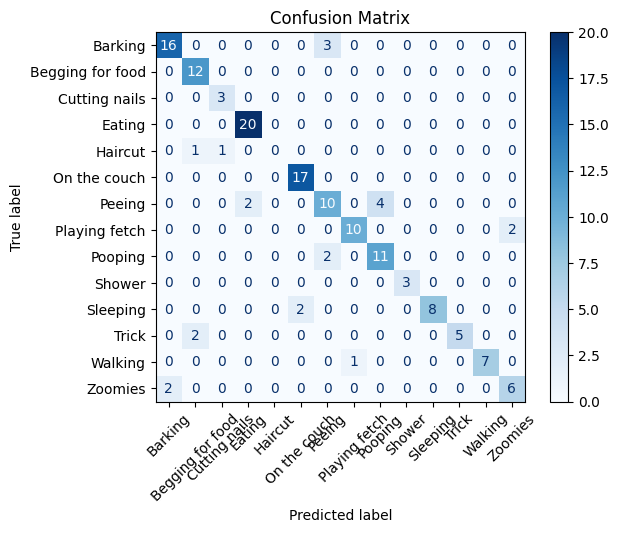

Model saved as 'model.pkl'


In [ ]:
# Confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
ConfusionMatrixDisplay(cm, display_labels=best_model.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()

In [90]:
# Save model
joblib.dump(best_model, 'model.pkl')
print("Model saved as 'model.pkl'")

Model saved as 'model.pkl'
